# Exercise 10: Global air temperature network

In [343]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import math

from netCDF4 import Dataset
from netCDF4 import num2date
import cartopy.crs as ccrs

import networkx as nx
import collections

%matplotlib inline

## 1. 
Import the global air temperature data set and familiarise yourself with it. What is the temporal resolution of the data? Which longitudes and latitudes are covered? Which time period is covered? Visualise global air temperatures (averaged over the full time period) using Basemap or Cartopy.

In [344]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print('\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print("NetCDF dimension information:")
        for dim in nc_dims:
            print("\tName:", dim) 
            print("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print('\tName:', var)
                print("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [345]:
# import the data set
nc_fid = Dataset("air.mon.mean.nc",'r')

# checking the information on the dataset
print(nc_fid)
nc_attrs, nc_dims, nc_vars = ncdump(nc_fid)

<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    References:

In [346]:
# extracting indvidual variables
lat = ma.getdata(nc_fid.variables['lat'][:])
lon = ma.getdata(nc_fid.variables['lon'][:])
time = ma.getdata(nc_fid.variables['time'][:])
temp = ma.getdata(nc_fid.variables['air'][:])   

# checking the type = numpy array, shape 
print(type(lat), lat.shape) # one dimension array
print(type(lon), lon.shape) # one dimension array
print(type(time), time.shape) # one dimension array(vector)
print(type(temp), temp.shape) # three dimension array / air temperature = temperature value(time, longtitude, latitude)
print(temp[1,1,1]) # temperature at first time, in first latitude and first longtitude

<class 'numpy.ndarray'> (73,)
<class 'numpy.ndarray'> (144,)
<class 'numpy.ndarray'> (876,)
<class 'numpy.ndarray'> (876, 73, 144)
-34.476204


### Temporal resolution 

In [347]:
# checking the temporal resolution
time_meta = nc_fid.variables['time'] 
time_ncdata = nc_fid.variables['time'][:]
print(time_meta.units)
print(time_meta[1]-time_meta[0])
744/24

# checking the time period
cal = getattr(time_meta, "calendar", "standard") #calling the calendar attribute from metadata
dates = num2date(time_ncdata, units = time_meta.units, calendar = cal) # 

print(dates[0])
print(dates[-1])

hours since 1800-01-01 00:00:0.0
744.0
1948-01-01 00:00:00
2020-12-01 00:00:00


First, checking the units. when you check the unit of netCDF file, you should apporach nc.fid.variables (metadata), not converted data(np.array). It's unit is hours. 
Next, Checking the hours interval. time[1]-time[0] = 744 hours. it means 31 days = one month. 
-> This data is monthly mean temperature data.

Second, Checking the last date and first date of the time for checking the time period.
first date is 1948-01-01, the last date is 2020-12-01.

### Coverage of latitudes, longtitudes


In [348]:
# checking the spatial range
lat_meta = nc_fid.variables['lat'] 
lat_ncdata = nc_fid.variables['lat'][:]
print(lat_meta.units)
print(lat_meta[2]-lat_meta[3])
print(np.min(lat), np.max(lat))

lon_meta = nc_fid.variables['lon'] 
print(lon_meta.units)
print(lon_meta[0]-lon_meta[1])
print(np.min(lon), np.max(lon))
print(lon_meta[0], lon_meta[1])

degrees_north
2.5
-90.0 90.0
degrees_east
-2.5
0.0 357.5
0.0 2.5


- Latitude : +90'N to -90'N (interval : 2.5 degrees_north)
- Longtitude : 0'E to 357.5'E (interval :2.5 degrees_east )

### Visualise global air temperatures

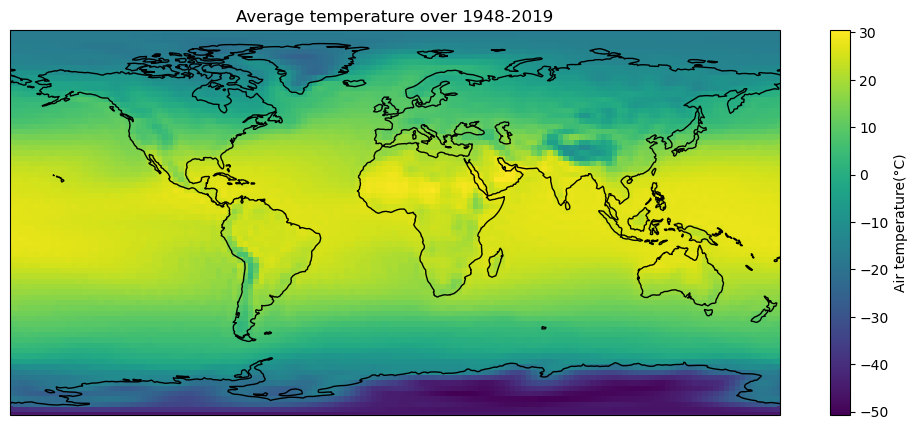

In [349]:
mean_temp = np.mean(temp, axis=0)

plt.figure(figsize=(13,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon, lat, mean_temp,
               transform=ccrs.PlateCarree(),
               shading='auto')
plt.colorbar(label='Air temperature(°C)')
plt.title("Average temperature over 1948-2019")
plt.show()

## 2.
Compute anomalies, i.e., detrend each time series by subtracting the respective seasonal variation. Why is this an important pre-processing procedure? Is there a trend left in the resulting temperature anomalies? (2P)

I have temperature data for each 12 month in a year. When to subtract the seasonal change for each time series, you should subtract 'mean tempearture for each month at full time period' from each time series. 

In [350]:
# caclulating month average temperature

month_mean = []

for k in range(12):
    mo_mean = np.mean(temp[k::12], axis=0) # temp[time,lat,lon] axis=0 mean calculate average along the line of time
    month_mean.append(mo_mean)

print(month_mean[1][2][2]) # January average temperature for whole time period in specific location
print(month_mean[1][2][2]) # June average temperature for whole time period in specific location

-30.567854
-30.567854


In [351]:
temp_anomal = np.zeros_like(temp)

for t in range(temp.shape[0]):
    month = t % 12
    temp_anomal[t] = temp[t] - month_mean[month]

print(temp_anomal.shape)

(876, 73, 144)


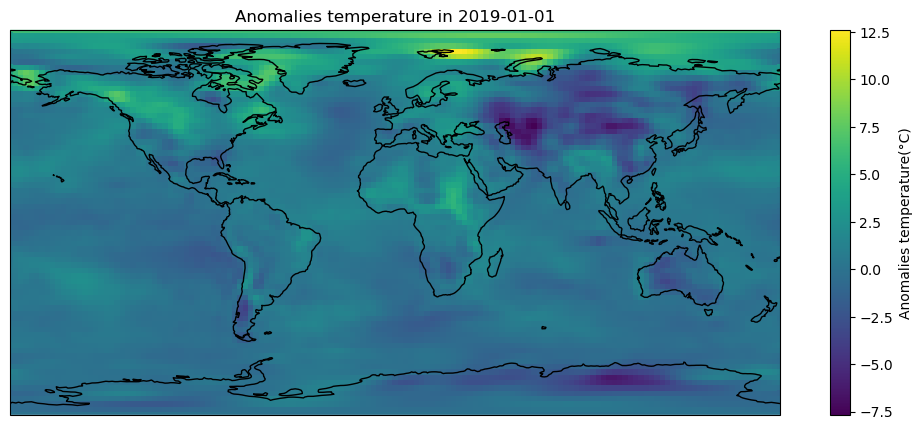

In [352]:
# Global temperature anomalies in specific date
plt.figure(figsize=(13,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lon, lat, temp_anomal[-1],
               transform=ccrs.PlateCarree(),
               shading='auto')
plt.colorbar(label='Anomalies temperature(°C)')
plt.title("Anomalies temperature in 2019-01-01")
plt.show()

35.0 127.5


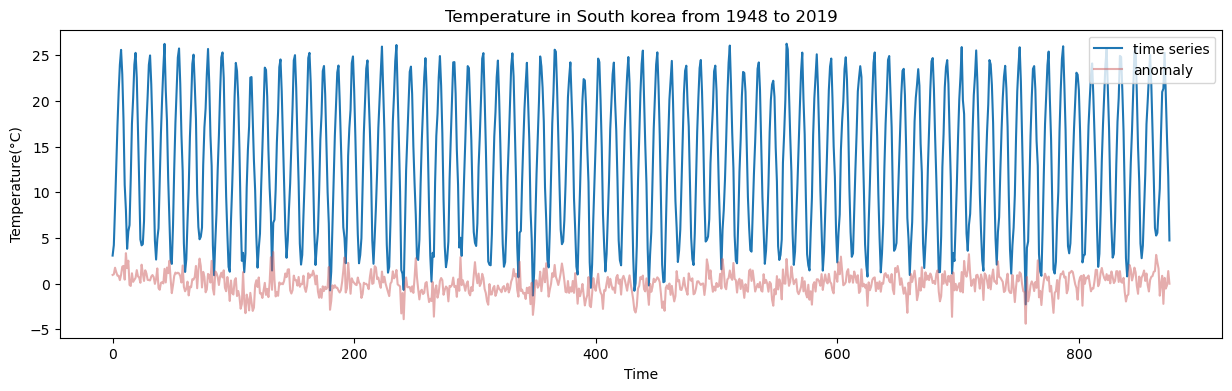

In [353]:
# Specific location - South Korea (35.9078° N, 127.7669° E)
print(lat[22],lon[51]) 

temp_sudkorea = []
for k in range(temp.shape[0]):
    temp_sudkorea.append(temp[k][22][51])

month_mean_sudkorea = []
for k in range(12):
    mo_mean = np.mean(temp[k::12,22,51]) # temp[time,lat,lon]
    month_mean_sudkorea.append(mo_mean)

temp_anomal_sudkorea = []
for t in range(temp.shape[0]):
    month = t % 12
    temp_anomal_sudkorea.append(temp[t][22][51] - month_mean_sudkorea[month])

t = range(temp.shape[0])

## plot anomalies time series of South Korea
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(t, temp_sudkorea, label='time series')
ax.plot(t, temp_anomal_sudkorea, color='indianred', alpha=.5, label='anomaly')
plt.xlabel("Time")
plt.ylabel("Temperature(°C)")
ax.set_title("Temperature in South korea from 1948 to 2019")
ax.legend()
plt.show()


It is important to eliminate the seasonal variation from data. For detecting real fluctuation trend, not from seasonal change, we want to see long term temperature change trend and also variations by ENSO, and some noise. In the result, there is a remain trend - long term trend by global warming.

## 3.
Generate an adjacency matrix to obtain a network representation of global air temperature anomalies over the full period of time. In particular, compute pairwise linear correlations between all anomaly time series and apply a suitable threshold to the correlation matrix (e.g., such that the resulting network has a density of 5%). Discard all self-links. Plot and discuss the resulting adjacency matrix.

In this 3-dimensional temperature data, you should caculate the similarity of value(anomalies) between each nodes.  
nodes are the each locations on the map - in this code, each combination of longtitude and latitude.

x = longtitude 144, y = latitude 73

    number of nodes = 144 * 73 = 10,512 EA
    
    similarity matrix = 10512 x 10512


In [354]:
# temp_anomal = (anomal temperature, latitude, longtitude) shape : (876, 73, 144)
# (time, lat, lon) -> (time, node)

T, nlat, nlon = temp_anomal.shape
X = temp_anomal.reshape(T, nlat*nlon) # 10512 lat-lon combination -> convert to the 1-D array (anomalies temperature by time, location)
print(X.shape)

# Similarity matrix C
C = np.corrcoef(X, rowvar=False)
print(C.shape)

# Threshold
thr = np.percentile(np.abs(C), 95) # density of 5%
A = (np.abs(C) >= thr).astype(int) # A[node x, node y] = 1 -> the same as edge list
np.fill_diagonal(A, 0) # discard all self-links
print(np.sum(A) / A.size) # only 5% of A have value

(876, 10512)
(10512, 10512)
0.04990487786372724


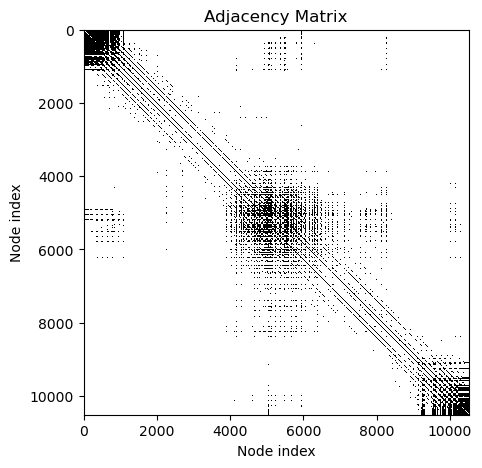

In [355]:
plt.figure(figsize=(5,5))
plt.imshow(A, cmap='binary', interpolation='none')
plt.title('Adjacency Matrix')
plt.xlabel('Node index')
plt.ylabel('Node index')
plt.show()

Even after deleting the self-link (the main diagonal), still this Adjacency shows multiple line around diagonal. This is because the area near diagonal means close locations have similar anomalies pattern each other.  But I also recognize that there is a strong correlation in the central, this is a interconnection group, connecting each other strongly. This is not from close location, is from specific area where nodes are connected with different kinds of nodes in other areas.

## 4.
Compute the degree of each node using the networkx degree-attribute. Reshape it such that it can be plotted on the world map. (3P)

In [356]:
deg = A.sum(axis=1)   # A[node x, node y] -> so if I sum along the axis =1, along all time period(875) (directon of vertical), I can get the degree of node y
print(deg[:10])
print(deg.mean(), deg.max())

lat_nodes = np.repeat(lat, nlon)
lon_nodes = np.tile(lon, nlat)  

[1021 1021 1021 1021 1021 1021 1021 1021 1021 1021]
524.6000761035008 2948


In [357]:
import scipy.sparse as sp

# convert A to network
A_sp = sp.csr_matrix(A)  
G = nx.from_scipy_sparse_array(A_sp)

# compute the degree of each node
deg_nx = np.array([d for _, d in G.degree()])
deg_map = deg_nx.reshape(nlat, nlon) # deg_nx is 1-D array, so I reshape this array to the map resolution - number of latitude, number of longtitude.

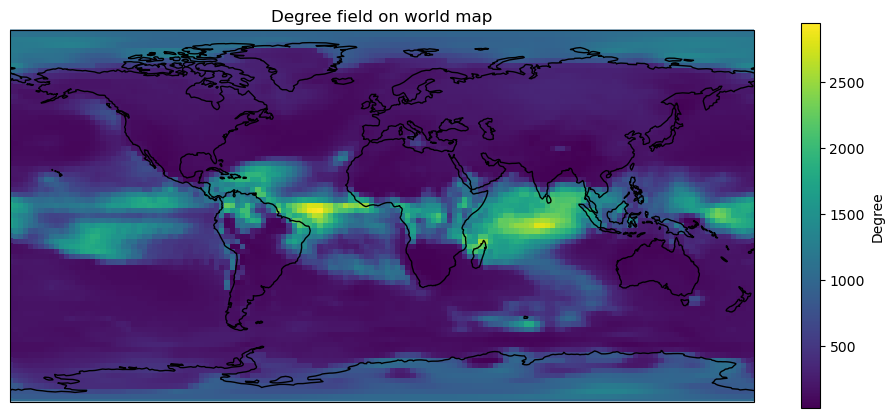

In [358]:

lon2d, lat2d = np.meshgrid(lon, lat)

plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

m = ax.pcolormesh(lon2d, lat2d, deg_map,
                  transform=ccrs.PlateCarree(),
                  shading='auto') # for converting index to real world-map longtitude, latitude

plt.colorbar(m, label='Degree')
plt.title('Degree field on world map')
plt.show()

In the adjacency Matrix, I could see the central hub area where the lot of nodes are connected each other, Now in this degree field, I can see the higest degree distribution is near by equator.

## 5.
Compute and visualize the area weighted connectivity field of global air temperature anomalies. To do so, implement a function that returns the area weighted connectivity of a node (without using the networkx node-attribute). Use Basemap to visualize it and to compare the node degrees (from 4) to the area weighted connectivity field. (8P)

try to write function by yourself ! understanding to connectivity

In [359]:
def plot_world(field2d, title, cbar_label):
    plt.figure(figsize=(12,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    m = ax.pcolormesh(lon2d, lat2d, field2d, transform=ccrs.PlateCarree(), shading='auto')
    plt.colorbar(m, label=cbar_label)
    plt.title(title)
    plt.show()

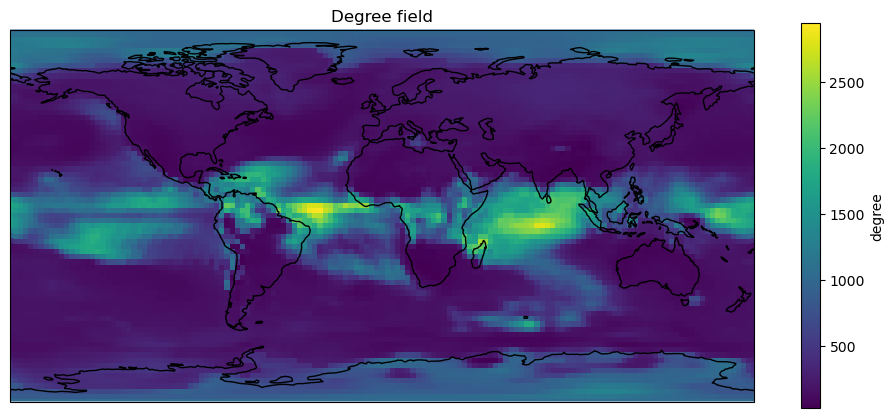

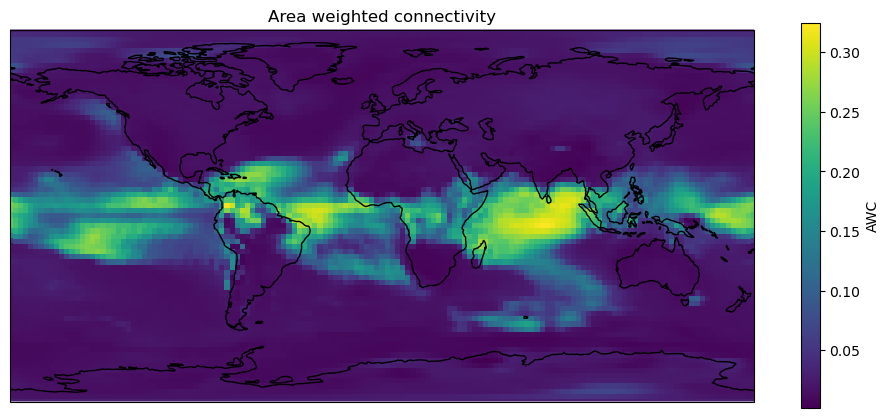

In [360]:
w = np.cos(np.deg2rad(lat_nodes)) 

def area_weighted_connectivity(i, A, w):
    num = np.sum(A[i, :] * w)
    den = np.sum(w)
    return num / den

awc = (A @ w) / np.sum(w)   # shape (N,)
awc_map = awc.reshape(nlat, nlon)

plot_world(deg_map, "Degree field", "degree")
plot_world(awc_map, "Area weighted connectivity", "AWC")

Area weighted connectivity : Earth is a sphere. A node is closer to the pole, the area is smaller than other nodes. It means even if the degree of a node near the pole is higher than another node, the node's affected area(which haslarge connectivity) can be smaller than the other nodes which has a lower degree. Because of this, I should compute weighted connectivity considering the area factor. 

(I used AI for drawing the map)

## 6.
Investigate whether there are links between temperature anomalies of very distant regions. Compute the geographical distribution of link lengths (in km) between all nodes in the global air temperature anomaly network. Plot the distribution with log-log-scale. Also plot the average geographical link length of each node using Basemap or Cartopy. Interpret your findings. (8P)

Edges: 2757298


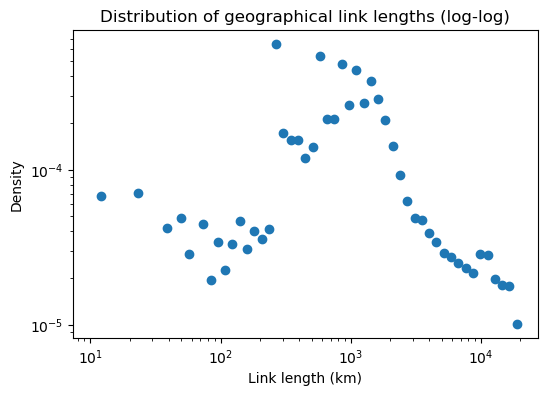

In [361]:
A_triu = sp.triu(A_sp, k=1).tocoo()
i = A_triu.row
j = A_triu.col
print("Edges:", len(i))

R = 6371.0  # km

lat_i = np.deg2rad(lat_nodes[i])
lon_i = np.deg2rad(lon_nodes[i])
lat_j = np.deg2rad(lat_nodes[j])
lon_j = np.deg2rad(lon_nodes[j])

dlat = lat_j - lat_i
dlon = lon_j - lon_i

a = np.sin(dlat/2)**2 + np.cos(lat_i)*np.cos(lat_j)*np.sin(dlon/2)**2
dist_km = 2*R*np.arcsin(np.sqrt(a))

bins = np.logspace(np.log10(10), np.log10(20000), 60)  # 10km~20000km
hist, edges = np.histogram(dist_km, bins=bins, density=True)
centers = np.sqrt(edges[:-1] * edges[1:])

plt.figure(figsize=(6,4))
plt.loglog(centers, hist, marker='o', linestyle='None')
plt.xlabel("Link length (km)")
plt.ylabel("Density")
plt.title("Distribution of geographical link lengths (log-log)")
plt.show()

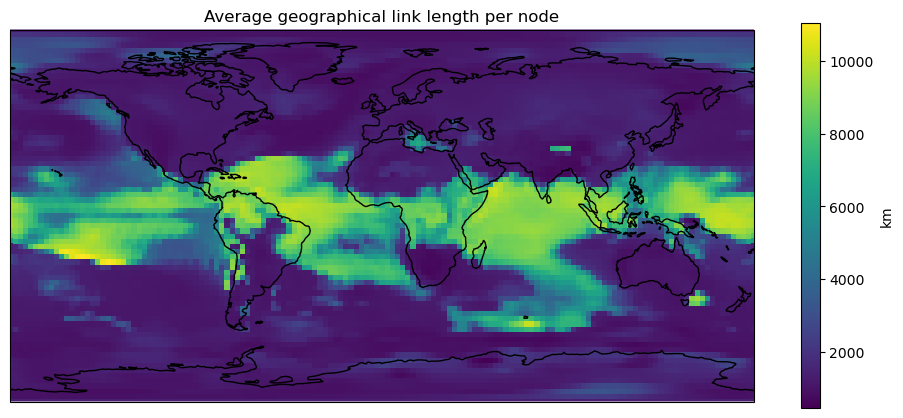

In [364]:
N = nlat * nlon
sumdist = np.bincount(i, weights=dist_km, minlength=N) + np.bincount(j, weights=dist_km, minlength = N)

deg = A_sp.sum(axis=1).A1  # faster, same as degree
avgdist = sumdist / np.maximum(deg, 1)  # remain 0 degree

avgdist_map = avgdist.reshape(nlat, nlon)
plot_world(avgdist_map, "Average geographical link length per node", "km")

(I was supported by AI)
- Degree field: Many nearby grid points are connected, so we see strong bands from local connections. Some regions also have high degree because they are connected to very distant regions (teleconnections).

- AWC field: A node can have a high degree but still a low AWC if it is mainly connected to small high-latitude grid cells. On the other hand, a node with a medium degree can have a high AWC if it is connected to regions with large surface area.

- Link length distribution: Most links are very short, but there are also some very long links. These long links show that teleconnections really exist in the network.

- Average link length map: Regions with a large average link length are more strongly connected to faraway regions. These areas may be centers or important parts of large-scale climate patterns.